# ECE 580 Project Code: Unigram TF-IDF and CountVectorizer on Multiple Models
## Fake News Detection using SVM and TF-IDF
- Rebecca Du (rrd17)
- Anish Parmar (avp30)

## Notebook Overview

In this notebook, we assess the performance of **Logistic Regression and SVM (Linear kernel)**. 

We employ the following setup:
- **Model**: Logistic Regression, SVM (Linear Kernel)
- **Vectorizers**: TF-IDF (unigram), CountVectorizer
- **Stopwords**: Removed

# Imports

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
#Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rebec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1: Data Preprocessing

## Overview:

We are using the [ISOT Fake News Kaggle Dataset (2016-2017)](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset). It is a dataset formed by news articles various sources. 

It is composed of 2 CSV files:
- **'Fake.csv'**: 23,481 articles from various unreliable websites
- **'True.csv'**: 21,417 articles from Reuters.com

Each data point contains the following features:
- **Title**: The title of the article
- **Text**: The full body of text in the article
- **Subject**: News, Politics, Other
- **Date**: Date of publication in 'Month Day, Year' format

## Step 1a: Load, Label, Combine Datasets

Since the Fake and True datasets are provided separately, we first **assign them labels and concatenate them into one dataframe**, which will be randomized and later used for training and testing our model. 

In [8]:
#Load datasets as dataframes
fake_df = pd.read_csv('Data/Fake.csv')
true_df = pd.read_csv('Data/True.csv')

In [9]:
#Check fake_df
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [10]:
#Check true_df
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [11]:
#Label fake_df values as '0', true_df values as '1'
fake_df['label'] = 0
true_df['label'] = 1

#Combine datasets into one
data = pd.concat([fake_df, true_df], ignore_index=True)

#Check data
data

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


## Step 1b: Combine Relevant Columns into 'Content'

Since we are mostly focused on the content of the articles, we will combine the title with the text columns and drop everything except the 'content' and 'label' columns.

In [13]:
#Combine title and text into 'content' column
data['content'] = data['title'] + ' ' + data['text']

#Drop other columns (except for label)
data = data.drop(columns=['title', 'text', 'subject', 'date'])

#Check data
data

,label,content
0,0,Donald Trump Sends Out Embarrassing New Year’...
1,0,Drunk Bragging Trump Staffer Started Russian ...
2,0,Sheriff David Clarke Becomes An Internet Joke...
3,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,0,Pope Francis Just Called Out Donald Trump Dur...
...,...,...
44893,1,'Fully committed' NATO backs new U.S. approach...
44894,1,LexisNexis withdrew two products from Chinese ...
44895,1,Minsk cultural hub becomes haven from authorit...
44896,1,Vatican upbeat on possibility of Pope Francis ...


## Step 1c: Text Cleaning

Next, we will do some simple cleaning of the 'content' column:
- Convert it to lowercase
- Remove punctuation
- Remove stopwords

In [15]:
#Create a function for the data preprocessing tasks
def preprocessing(text):
    #Turn to lowercase
    text = text.lower()

    #Remove punctuation 
    text = re.sub(r'[^\w\s]', '', text)

    #Remove stopwords
    #Split text into individual words
    split_text = text.split()
    cleaned_text = []
    
    for word in split_text:
        if word not in stop_words:
            #Only keep non-stop word words
            cleaned_text.append(word)

    #Recombine into one string
    rejoined_text = ' '.join(cleaned_text)

    return rejoined_text

In [16]:
#Apply preprocessing function to data
data['content'] = data['content'].apply(preprocessing)

#Check to make sure it looks right
data

,label,content
0,0,donald trump sends embarrassing new years eve ...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes internet joke thr...
3,0,trump obsessed even obamas name coded website ...
4,0,pope francis called donald trump christmas spe...
...,...,...
44893,1,fully committed nato backs new us approach afg...
44894,1,lexisnexis withdrew two products chinese marke...
44895,1,minsk cultural hub becomes authorities minsk r...
44896,1,vatican upbeat possibility pope francis visiti...


## Step 1d: Train/Validation/Test Splitting

Now, we will split our cleaned data into training, validation, and testing sets. This will be useful for tuning hyperparameters and assessing model performance later on. 

The split we will choose is: 
- **Train**: 70%
- **Validation**: 15%
- **Test**: 15%

In [18]:
#Split into features (X) and labels (y)
X = data['content']
y = data['label']

In [19]:
#Split into train and temp 
train, temp_data = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)

#Split temp into validation & test
val, test = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

#Get features and labels for each split
X_train, y_train = train['content'], train['label']
X_val, y_val = val['content'], val['label']
X_test, y_test = test['content'], test['label']

In [20]:
# Display the distribution of Fake and Real News in nonprocessed and processed datasets after splitting

print("Processed Data Train, Validation, & Test Distribution")
print("Train Labels:", y_train.value_counts(normalize=True))
print("Validation Labels:", y_val.value_counts(normalize=True))
print("Test Labels:", y_test.value_counts(normalize=True))

Processed Data Train, Validation, & Test Distribution
Train Labels: label
0    0.522973
1    0.477027
Name: proportion, dtype: float64
Validation Labels: label
0    0.52294
1    0.47706
Name: proportion, dtype: float64
Test Labels: label
0    0.523088
1    0.476912
Name: proportion, dtype: float64


## Step 1e: Apply TF-IDF Vectorization

**TF-IDF** is a combination of 2 terms:
- **Term Frequency (TF)**: how frequently a term appears in one given document ($d$), calculated as:
$$
\text{TF(term, document)} = \frac{\text{Number of times the term appears in the document}}{\text{Total number of terms in the document}}
$$

- **Inverse Document Frequency (IDF)**: how unique the term ($t$) is across all the documents ($d$), calculated as:
$$
\text{IDF(term, corpus)} = \log \left( \frac{\text{Total number of documents}}{\text{1 + Number of documents containing the term}} \right)
$$

In practice, TF-IDF is a weighting technique that **gives higher weight to**:
- **High TF score** (frequent in one document)
- and **Low IDF score** (not too common across all documents)

Specifically, we will apply a **Unigram** TF-IDF vectorization method. This means that we will use **single words** (no phrases or pairs of words).

**We will fit the vectorizer on the training data only** to avoid 'cheating' (aka allowing the model to learn from the data in the validation/testing sets, which would give it an unfair advantage in later testing). We will then transform all the splits.

This will result in sparse matrices that transform the words of the text into numerical values suitable for the SVM to interpret.

In [22]:
#Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),       #Unigrams
    stop_words='english'      #Remove stop words again (just in case)
)

In [23]:
#Fit vectorizer on training data ONLY and transform
X_train_tfidf = vectorizer.fit_transform(X_train)

#Transform (NO FITTING TO AVOID CHEATING) validation, test sets
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

## Step 1f) Apply CountVectorizer Vectorization

**Count Vectorizer** is a similar technique that converts text data into numerical features. Specifically, it captures word patterns in the articles by representing each article as a vector of word frequencies. 

In [25]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_counts = vectorizer.fit_transform(X_train)

# Transform the validation and test data
X_val_counts = vectorizer.transform(X_val)
X_test_counts = vectorizer.transform(X_test)

# Step 2: Implementing Logistic Regression, Random Forest, Naive Bayes, & SVM

## Overview

Next, we will implement the various machine learning models that we want to test:
- Logistic Regression
- Random Forest
- Naive Bayes
- SVM

Each model was evaluated twice: first on data preprocessed by **TF-IDF**, then on data preprocessed by **Count Vectorizer**.

The following evaluation metrics were calculated using the obtained predictions and the test set:
- **Precision**: the proportion of predicted 'positives' (fake news instances) that are actually positive (fake):
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

- **Recall**: the proportion of actual fake news articles that are correctly identified
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$
- **F1 score**: the harmonic mean of precision and recall that's a good metric for assessing model performance if concerned about *both* precision and recall.
$$
\text{F1 Score} = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Finally, a confusion matrix and classification report was printed for evaluation on both test and validation sets. 

In [28]:
# Create function for calculating and printing precision, recall, f1 score, & confusion matrix 
# (only called for test set)
def model_evaluation(test, pred, name:string):
    precision = precision_score(test, pred)
    recall = recall_score(test, pred)
    f1 = f1_score(test, pred)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    print(f"\n{name} Classification Report:")
    print(classification_report(test, pred))

    cm = confusion_matrix(test, pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.xlabel(f'Predicted Labels ({name})')
    plt.ylabel('True Labels')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

## Step 2a) Logistic Regression

**Logistic Regression** is a linear model that calculates the probability of a binary problem (in our case, whether a given news article is real or fake). 

It does so based on a **linear combination of input features** (in our case, the word counts/frequencies from TF-IDF and CountVectorizer). 

Finally, it uses a **sigmoid activation function to map the linear combination to a probability** between $0$ (representing fake news) and $1$ (representing real news).

Below, we initialize, train, and validate a Logistic Regression model on data preprocessed with unigram TF-IDF then CountVectorizer.

### Step 2a.1) Logistic Regression (Unigram TF-IDF)

Precision: 0.9848156182212582
Recall: 0.9894146948941469
F1 Score: 0.987109799658332

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3523
           1       0.98      0.99      0.99      3212

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



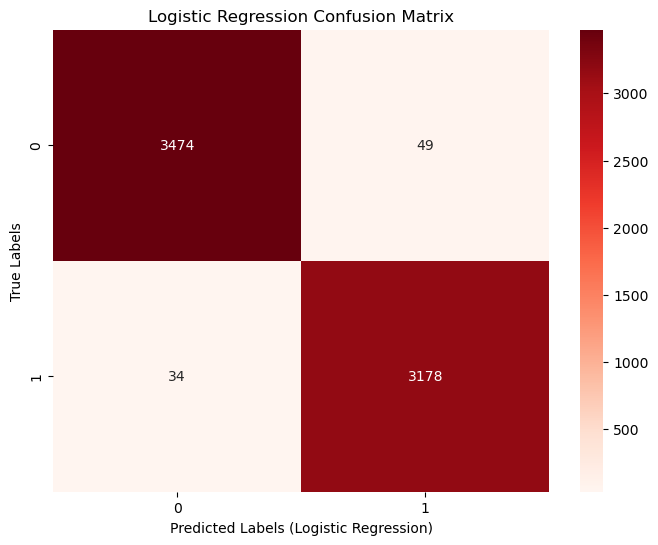

Logistic Regression (Unigram TF-IDF) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3522
           1       0.98      0.99      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



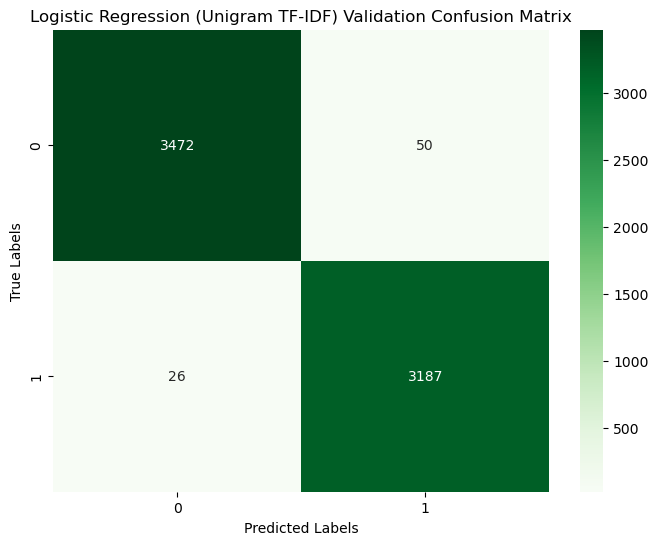

In [31]:
# Initialize & train Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)  
logistic_model.fit(X_train_tfidf, y_train)

# Make predictions on test set
lr_y_pred = logistic_model.predict(X_test_tfidf)

# Evaluate model
model_evaluation(y_test, lr_y_pred, "Logistic Regression")

# Validation set evaluation
y_val_pred = logistic_model.predict(X_val_tfidf)
print("Logistic Regression (Unigram TF-IDF) Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression (Unigram TF-IDF) Validation Confusion Matrix')
plt.show()

### Step 2a.2) Logistic Regression (Count Vectorizer)

Precision: 0.9975077881619938
Recall: 0.9968866749688667
F1 Score: 0.9971971348489567

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3523
           1       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



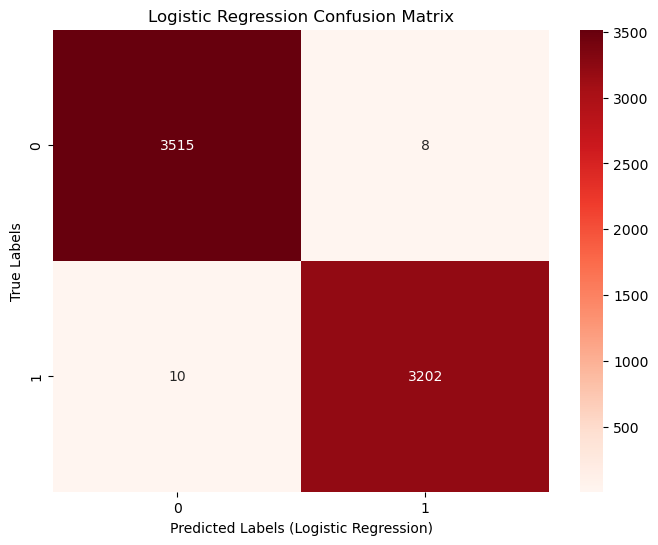

Logistic Regression (CountVectorizer) Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3522
           1       1.00      1.00      1.00      3213

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



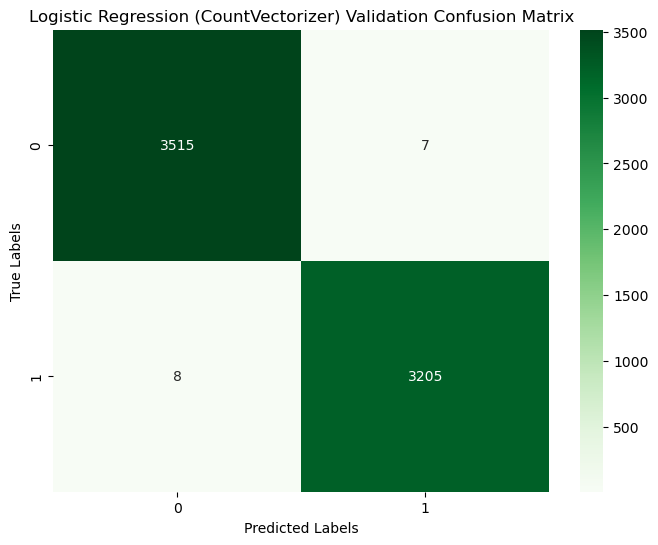

In [33]:
# With Count Vectorizer
logistic_model = LogisticRegression(max_iter=1000, random_state=42)  
logistic_model.fit(X_train_counts, y_train)

lr_y_pred = logistic_model.predict(X_test_counts)

model_evaluation(y_test, lr_y_pred, "Logistic Regression")

# Validation set evaluation
y_val_pred = logistic_model.predict(X_val_counts)
print("Logistic Regression (CountVectorizer) Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression (CountVectorizer) Validation Confusion Matrix')
plt.show()

## Step 2b) Random Forest

**Random Forest** is a machine learning algorithm that uses multiple decision trees and combines their individual predictions to make better prediction overall regarding the data. 

Each **decision tree** splits the data based on features and uses those features (in our case, word frequencies) to make decisions, leading the tree to conclude that the article is either Fake or Real. 

However, individual trees may overfit on the training data and be sensitive to noise and bias. Random Forest accounts for these issues by using **multiple trees**, each of which is given a **random subset of the overall data and features to make predictions on**. At the end, a majority vote of all the decision trees gives us the model's result. 

Below, we initialize, train, and validate a Random Forest model on data preprocessed with unigram TF-IDF then CountVectorizer.

### Step 2b.1) Random Forest (Unigram TF-IDF)

Precision: 0.9903726708074534
Recall: 0.9928393524283935
F1 Score: 0.9916044776119403

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3523
           1       0.99      0.99      0.99      3212

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



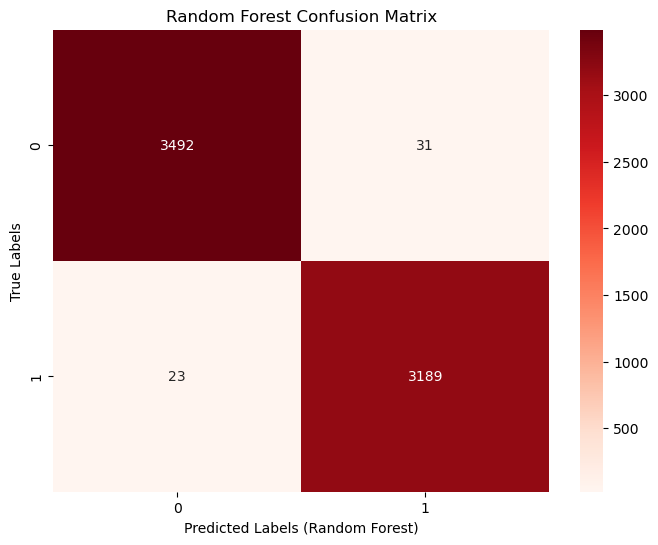

Random Forest (Unigram TF-IDF) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3522
           1       0.99      0.99      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



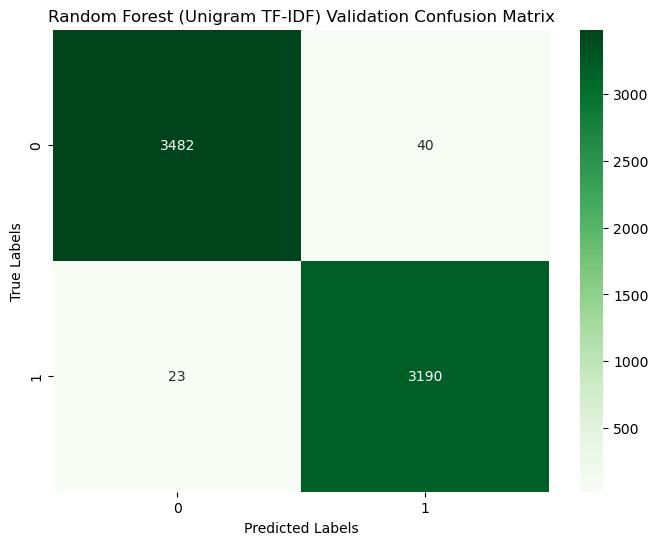

In [36]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_tfidf, y_train)
rf_y_pred = rf_model.predict(X_test_tfidf)

model_evaluation(y_test, rf_y_pred, "Random Forest")

# Validation set evaluation
y_val_pred = rf_model.predict(X_val_tfidf)
print("Random Forest (Unigram TF-IDF) Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Random Forest (Unigram TF-IDF) Validation Confusion Matrix')
plt.show()

### Step 2b.2) Random Forest (Count Vectorizer)

Precision: 0.9888579387186629
Recall: 0.9947073474470735
F1 Score: 0.9917740183144498

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3523
           1       0.99      0.99      0.99      3212

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



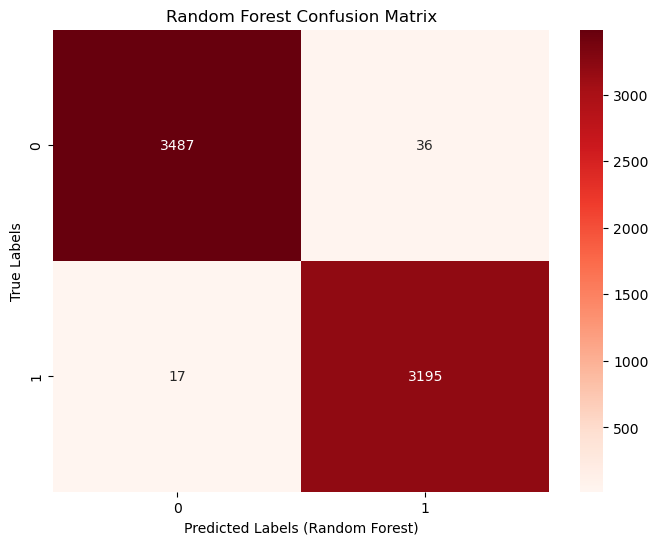

Random Forest (CountVectorizer) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3522
           1       0.99      0.99      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



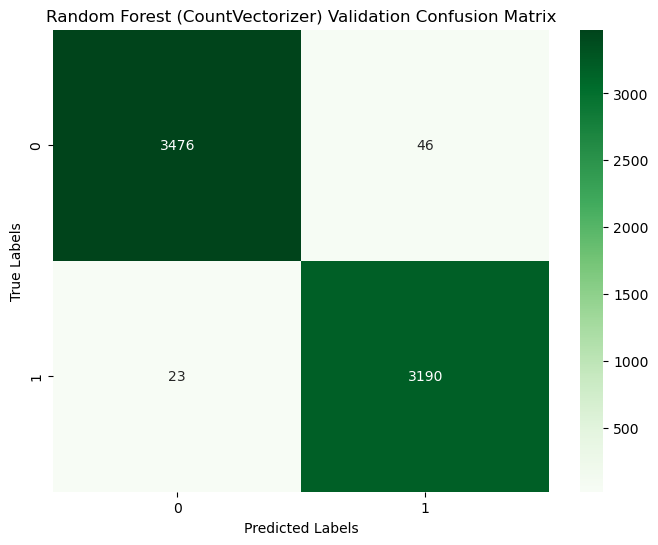

In [38]:
# With Count Vectorizer
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_counts, y_train)
rf_y_pred = rf_model.predict(X_test_counts)

model_evaluation(y_test, rf_y_pred, "Random Forest")

# Validation set evaluation
y_val_pred = rf_model.predict(X_val_counts)
print("Random Forest (CountVectorizer) Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Random Forest (CountVectorizer) Validation Confusion Matrix')
plt.show()

## Step 2c) Naive Bayes

The **Naive Bayes (MultinomialNB)** is a probabilistic model based on **Bayes' Theorem** with the naive assumption that **all features (e.g. word counts) are independent**. 

In our problem, the model does the following:
1) Calculates how often each word appears in fake articles vs. real articles
2) Uses the word probabilities to calculate:
$$P(\text{Fake} | \text{Words}) = \frac{P(\text{Words} | \text{Fake}) \cdot P(\text{Fake})}{P(\text{Words})}$$

$$P(\text{Real} | \text{Words}) = \frac{P(\text{Words} | \text{Real}) \cdot P(\text{Real})}{P(\text{Words})}$$

3) Predict the class (fake or real) with the higher of the two above probabilities.

In our problem, the model computes the probability of an article being fake or real news based on the words it contains, then it picks the class (fake or real) with the **highest probability**. 

Below, we initialize, train, and validate a Naive Bayes model on data preprocessed with unigram TF-IDF then CountVectorizer.

### Step 2c.1) Naive Bayes (Unigram TF-IDF)

Precision: 0.9329472721731179
Recall: 0.952988792029888
F1 Score: 0.9428615432003696

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3523
           1       0.93      0.95      0.94      3212

    accuracy                           0.94      6735
   macro avg       0.94      0.95      0.94      6735
weighted avg       0.95      0.94      0.94      6735



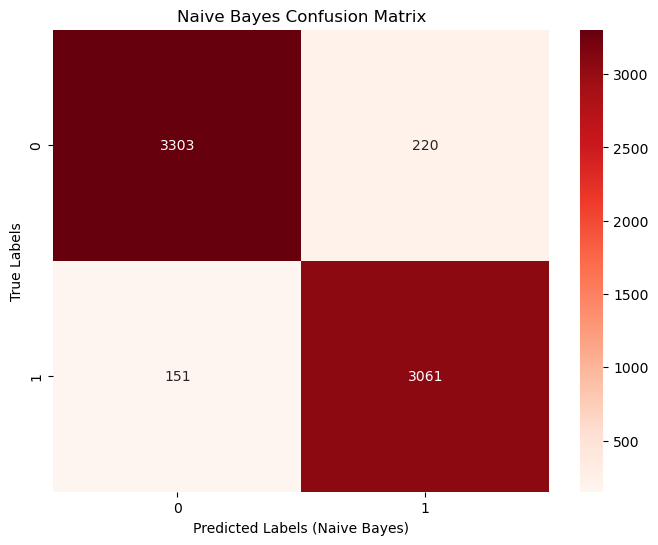

Naive Bayes (Unigram TF-IDF) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3522
           1       0.93      0.95      0.94      3213

    accuracy                           0.94      6735
   macro avg       0.94      0.94      0.94      6735
weighted avg       0.94      0.94      0.94      6735



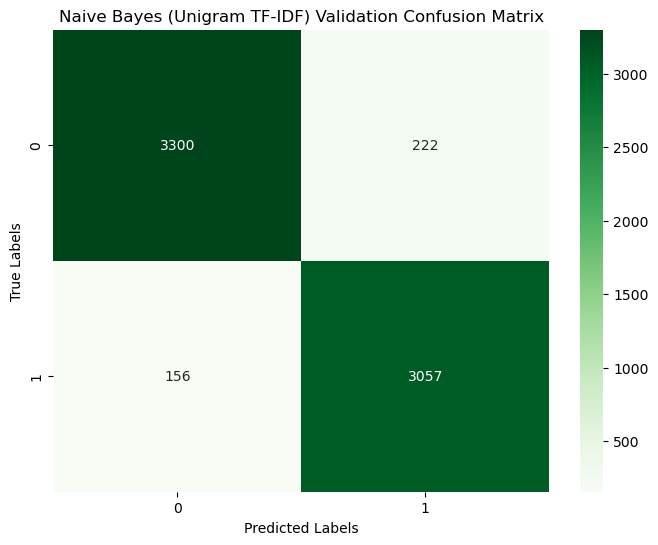

In [41]:
# MultinomialNB works with TF-IDF data
nb_model = MultinomialNB()  
nb_model.fit(X_train_tfidf, y_train)
nb_y_pred = nb_model.predict(X_test_tfidf)

model_evaluation(y_test, nb_y_pred, "Naive Bayes")

# Validation set evaluation
y_val_pred = nb_model.predict(X_val_tfidf)
print("Naive Bayes (Unigram TF-IDF) Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes (Unigram TF-IDF) Validation Confusion Matrix')
plt.show()

### Step 2c.2) Naive Bayes (Count Vectorizer)

Precision: 0.9525703794369645
Recall: 0.9691780821917808
F1 Score: 0.9608024691358025

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3523
           1       0.95      0.97      0.96      3212

    accuracy                           0.96      6735
   macro avg       0.96      0.96      0.96      6735
weighted avg       0.96      0.96      0.96      6735



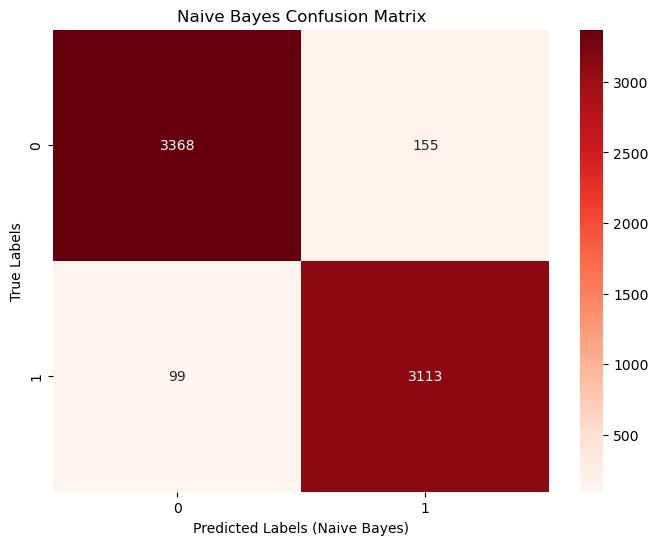

Naive Bayes (CountVectorizer) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3522
           1       0.95      0.97      0.96      3213

    accuracy                           0.96      6735
   macro avg       0.96      0.96      0.96      6735
weighted avg       0.96      0.96      0.96      6735



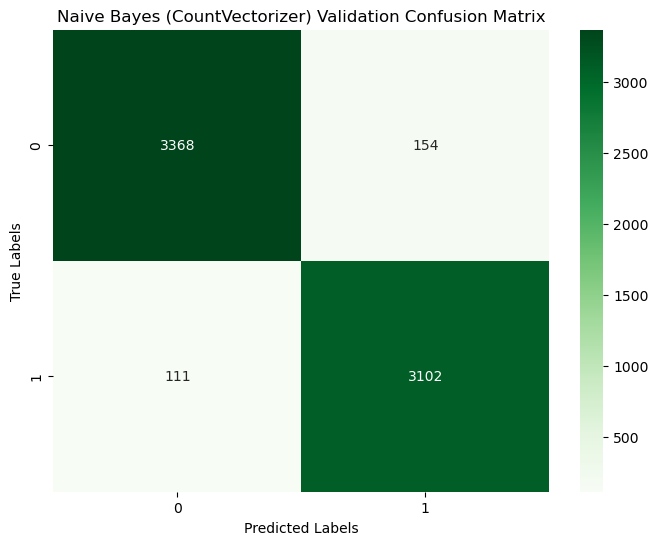

In [43]:
# With Count Vectorizer
nb_model = MultinomialNB()  
nb_model.fit(X_train_counts, y_train)
nb_y_pred = nb_model.predict(X_test_counts)

model_evaluation(y_test, nb_y_pred, "Naive Bayes")

# Validation set evaluation
y_val_pred = nb_model.predict(X_val_counts)
print("Naive Bayes (CountVectorizer) Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes (CountVectorizer) Validation Confusion Matrix')
plt.show()

## Step 2d) SVM

The **Support Vector Machine (SVM)** is a supervised learning algorithm used for classification. The algorithm works by finding the **best decision boundary** that separates data points from different classes. 

This boundary is determined by **support vectors** - key data points closest to the boundary that help define the margin. The SVM selects the boundary with the greatest margin (i.e. the largest distance to the points of each class for the clearest differentiation). 

SVM works especially well on high-dimensional text data, like the kind in our problem. 

Below, we initialize, train, and validate a SVM model on data preprocessed with unigram TF-IDF then CountVectorizer.

### Step 2d.1) SVM (Unigram TF-IDF)

Precision: 0.9940883634100809
Recall: 0.9947073474470735
F1 Score: 0.9943977591036415

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3523
           1       0.99      0.99      0.99      3212

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



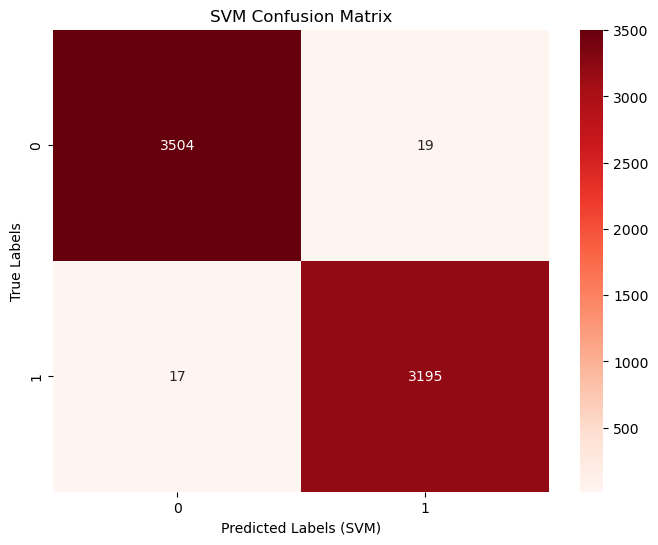

SVM (Unigram TF-IDF) Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3522
           1       0.99      1.00      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



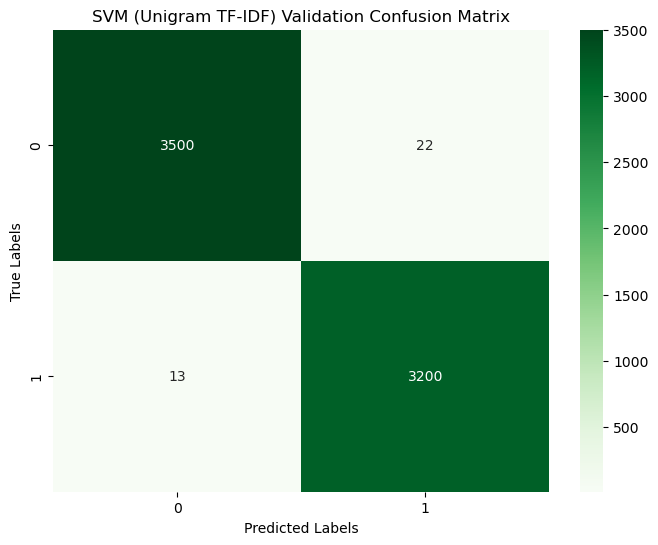

In [46]:
svm_model = SVC(kernel='linear', C=1, random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Predictions on the test set
y_pred = svm_model.predict(X_test_tfidf)

model_evaluation(y_test, y_pred, "SVM")

# Validation set evaluation
y_val_pred = svm_model.predict(X_val_tfidf)
print("SVM (Unigram TF-IDF) Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM (Unigram TF-IDF) Validation Confusion Matrix')
plt.show()

### Step 2d.2) SVM (Count Vectorizer)

Precision: 0.9971910112359551
Recall: 0.9947073474470735
F1 Score: 0.9959476309226932

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3523
           1       1.00      0.99      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



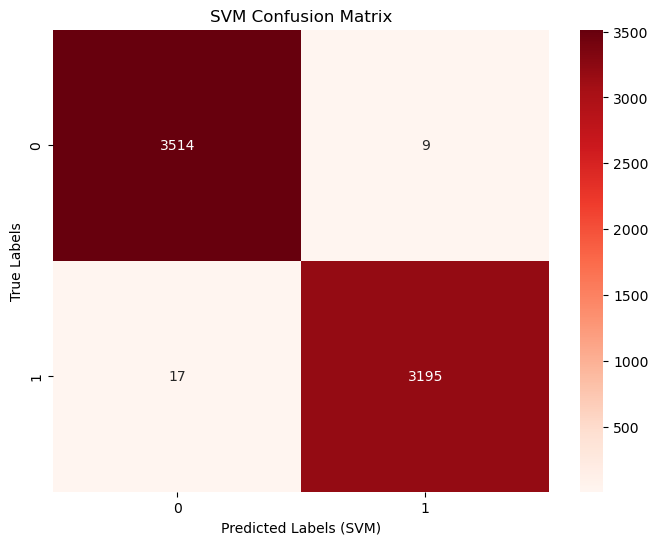

SVM (CountVectorizer) Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3522
           1       1.00      1.00      1.00      3213

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



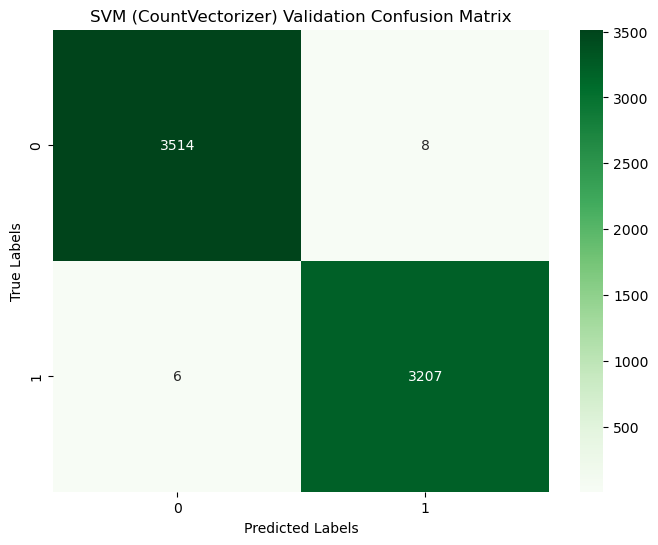

In [48]:
# With Count Vectorizer
svm_model = SVC(kernel='linear', C=1, random_state=42)
svm_model.fit(X_train_counts, y_train)

# Predictions on the test set
y_pred = svm_model.predict(X_test_counts)

model_evaluation(y_test, y_pred, "SVM")

# Validation set evaluation
y_val_pred = svm_model.predict(X_val_counts)
print("SVM (CountVectorizer) Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM (CountVectorizer) Validation Confusion Matrix')
plt.show()

## Step 3) Hyperparameter Tuning SVM

## Overview

Since SVM is one of the best-performing models, we want to investigate how we can further improve its performance by performing hyperparameter tuning. 

Specifically, we want to focus on the $C$ variable, a regularization parameter that controls the **tradeoff between maximizing the margin and minimizing classification error**. 

A **high $C$** value results in the model trying to classify each training sample correctly. This leads to:
- A **smaller margin** (less tolerance for misclassified points)
- Overfitting

In contrast, a **low $C$** value results in: 
- A larger margin (slightly more tolerance for misclassified points, which is good for **generalization**)
- Underfitting

Below, we test the effect of different values of $C$ on model performance to choose the one that is best for the task at hand. Here, we keep CountVectorizer as the preprocessing technique as it yielded a better F1 score for the SVM model.

In [51]:
# Using count vectorizer since it yielded a higher F1 for SVM compared to TF-IDF

C_vals = [0.01, 0.1, 1, 10, 100]

best_f1 = 0
best_C = None

for C in C_vals:
    svm_model = SVC(kernel='linear', C=C, random_state=42)
    svm_model.fit(X_train_counts, y_train) 
    y_val_pred = svm_model.predict(X_val_counts)
    report = classification_report(y_val, y_val_pred, output_dict=True)

    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    print(f"C: {C}, Precision: {precision:.10f}, Recall: {recall:.10f}, F1: {f1:.10f}")

    if f1 > best_f1:
        best_f1 = f1
        best_C = C

print(f"Best C: {best_C}, Best Validation F1: {best_f1}")

# Train final model (with best c) on combined training & validation sets
final_svm = SVC(kernel='linear', C=best_C, random_state=42)
final_svm.fit(X_train_counts, y_train)
y_test_pred = final_svm.predict(X_test_counts)
print(classification_report(y_test, y_test_pred))

C: 0.01, Precision: 0.9976274236, Recall: 0.9976243504, F1: 0.9976244768
C: 0.1, Precision: 0.9976251837, Recall: 0.9976243504, F1: 0.9976244144
C: 1, Precision: 0.9979215394, Recall: 0.9979213066, F1: 0.9979213348
C: 10, Precision: 0.9979215394, Recall: 0.9979213066, F1: 0.9979213348
C: 100, Precision: 0.9979215394, Recall: 0.9979213066, F1: 0.9979213348
Best C: 1, Best Validation F1: 0.9979213348032374
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3523
           1       1.00      0.99      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



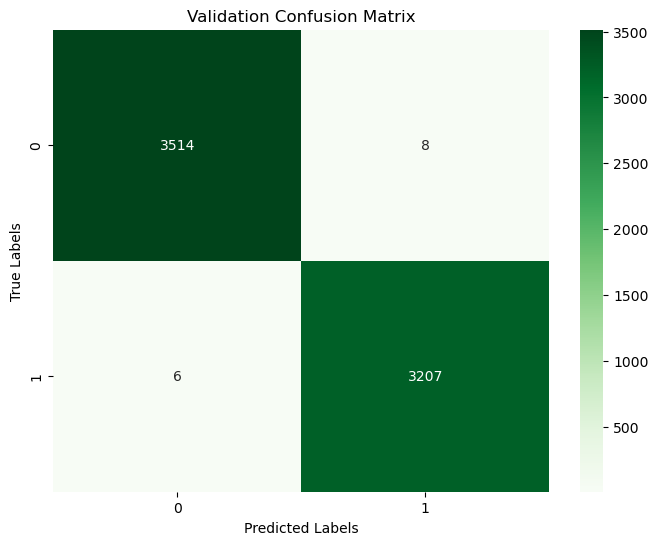

In [52]:
cm = confusion_matrix(y_val, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Validation Confusion Matrix')
plt.show()